# TODO

- remove 'your name'
- tokenize
- cross validation on clustering? 
- using longest responses?

In [1]:
import random
import numpy as np

random.seed(0)
np.random.seed(0)

In [2]:
HUMAN = "human"

GEMINI_10 = "gemini-1.0-pro"
GEMINI_15 = "gemini-1.5-pro-latest"

CLAUDE_SONNET = "claude-3-sonnet-20240229"
CLAUDE_OPUS = "claude-3-opus-20240229"

GPT_35 = "gpt-3.5-turbo-0125"
GPT_40 = "gpt-4-turbo-2024-04-09"


authors = [HUMAN, GEMINI_10, GEMINI_15, CLAUDE_SONNET, CLAUDE_OPUS, GPT_35, GPT_40]

# Function words

In [3]:
with open("function_words/oshea.txt") as f:
    lines = f.readlines()
    fw_oseah = [line.split()[0] for line in lines]

# Z-Scores

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import pandas as pd


class ZScoreTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, function_words):
        self.function_words = function_words
        self.vectorizer = TfidfVectorizer(
            use_idf=False, norm=None, tokenizer=word_tokenize, token_pattern=None
        )
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        # Fit the vectorizer to the corpus
        word_counts = self.vectorizer.fit_transform(X).toarray()

        # oov = [
        #    word
        #    for word in self.function_words
        #    if word not in self.vectorizer.vocabulary_
        # print(f"{len(oov)} words not in corpus: {oov}")

        # Fit z-score scaler to the relative frequencies
        relative_freqs = word_counts / word_counts.sum(axis=1, keepdims=True)
        self.scaler.fit(relative_freqs)
        return self

    def transform(self, X):
        # Transform the corpus into word counts
        word_counts = self.vectorizer.transform(X).toarray()

        # Calculate the relative frequencies
        relative_freqs = word_counts / word_counts.sum(axis=1, keepdims=True)

        # Calculate the z-scores
        z_scores = self.scaler.transform(relative_freqs)

        fw_indices = [
            self.vectorizer.vocabulary_[word]
            for word in self.function_words
            if word in self.vectorizer.vocabulary_
        ]

        # Keep the relative frquencies of only the function words
        fw_z_scores = z_scores[:, fw_indices]

        return fw_z_scores

# Deltas

In [5]:
def delta(z_scores, variant):
    if variant == "burrows":
        return cdist(z_scores, z_scores, metric="cityblock")
    if variant == "cosine":
        return cdist(z_scores, z_scores, metric="cosine")

    raise ValueError(f"Unknown variant: {variant}")

# Classification

In [6]:
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


def classify(df, function_words):
    # Train-test split
    prompt_ids = df["prompt_id"].unique().tolist()
    test_prompts = random.sample(prompt_ids, 2)
    df_test = df[df["prompt_id"].isin(test_prompts)].reset_index(drop=True)
    df_train = df[~df["prompt_id"].isin(test_prompts)].reset_index(drop=True)

    # Use the ZScoreTransformer to get the z-scores
    z_scores_transformer = ZScoreTransformer(function_words)
    z_scores_train = z_scores_transformer.fit_transform(df_train["text"])
    z_scores_test = z_scores_transformer.transform(df_test["text"])

    # Set up cross-validation
    train_indices_by_prompt = (
        df_train.groupby("prompt_id")
        .apply(lambda x: x.index, include_groups=False)
        .tolist()
    )
    cv_iterable = []
    for _ in range(3):
        train_indices_by_prompt = (
            train_indices_by_prompt[2:] + train_indices_by_prompt[:2]
        )
        val_indices = np.concatenate(train_indices_by_prompt[:2])
        train_indices = np.concatenate(train_indices_by_prompt[2:])
        cv_iterable.append((train_indices, val_indices))

    # Train the model using grid search
    model = GridSearchCV(
        LogisticRegression(max_iter=1000),
        param_grid={
            "C": [0.001, 0.003, 0.01, 0.03, 0.1],
            "solver": ["liblinear", "lbfgs"],
        },
        cv=cv_iterable,
        n_jobs=-1,
        refit=True,
    )

    model.fit(z_scores_train, df_train["author"])
    y_pred = model.predict(z_scores_test)

    return df_test["author"], y_pred

## All 7 authors

In [22]:
from sklearn.metrics import classification_report


for dataset in ["reddit", "hewlett"]:
    dfs = []
    for author in authors:
        df = pd.read_csv(f"{dataset}_responses/{author}.csv")
        df["author"] = author
        dfs.append(df)
    df = pd.concat([df for df in dfs], ignore_index=True)

    y_true, y_pred = classify(df, fw_oseah)
    report = classification_report(y_true, y_pred, zero_division=0)
    print(f"Dataset: {dataset}")
    print(report)

23 words not in corpus: ['whyever', 'thereupon', 'whereafter', 'whereby', 'whereupon', 'furthermore', 'anyhow', 'eg', 'ie', 'thence', 'thru', 'cannot', 'hereabouts', 'hereinafter', 'heretofore', 'herewith', 'hereunder', 'hereupon', 'latterly', 'oftentimes', 'thereabouts', 'thereon', 'whither']
Dataset: reddit
                          precision    recall  f1-score   support

  claude-3-opus-20240229       0.41      0.40      0.41       200
claude-3-sonnet-20240229       0.56      0.17      0.27       200
          gemini-1.0-pro       0.64      0.66      0.65       200
   gemini-1.5-pro-latest       0.65      0.71      0.68       200
      gpt-3.5-turbo-0125       0.62      0.51      0.56       200
  gpt-4-turbo-2024-04-09       0.60      0.58      0.59       200
                   human       0.52      0.93      0.66       200

                accuracy                           0.57      1400
               macro avg       0.57      0.57      0.54      1400
            weighted avg   

## Pairwise with human and each LLM

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

llms = [GEMINI_10, GEMINI_15, CLAUDE_SONNET, CLAUDE_OPUS, GPT_35, GPT_40]
n_trials = 10

for dataset in ["reddit", "hewlett"]:
    results = []
    for llm in tqdm(llms * n_trials):
        df_llm = pd.read_csv(f"{dataset}_responses/{llm}.csv")
        df_human = pd.read_csv(f"{dataset}_responses/{HUMAN}.csv")
        df_llm["author"] = llm
        df_human["author"] = HUMAN
        df = pd.concat([df_llm, df_human], ignore_index=True)

        y_true, y_pred = classify(df, fw_oseah)
        report = classification_report(
            y_true, y_pred, zero_division=0, output_dict=True
        )
        results.append({"dataset": dataset, "llm": llm, "accuracy": report["accuracy"]})

    results_df = pd.DataFrame(results)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="llm", y="accuracy", data=results_df)
    plt.title(f"{dataset.capitalize()} dataset")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45)
    plt.show()

# Clustering

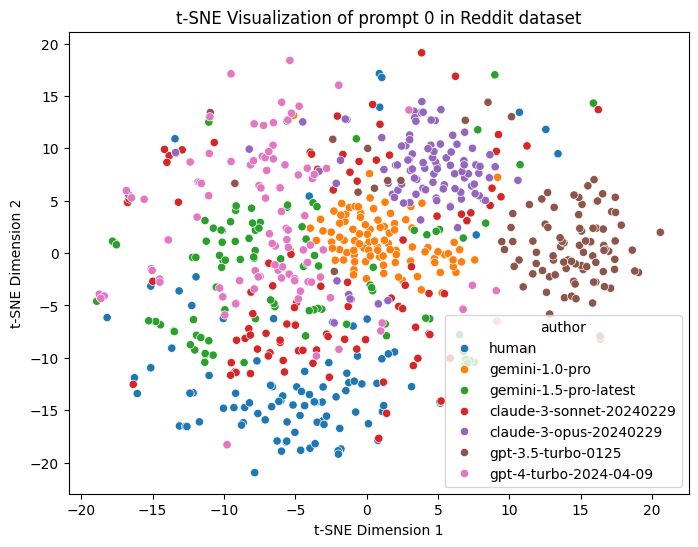

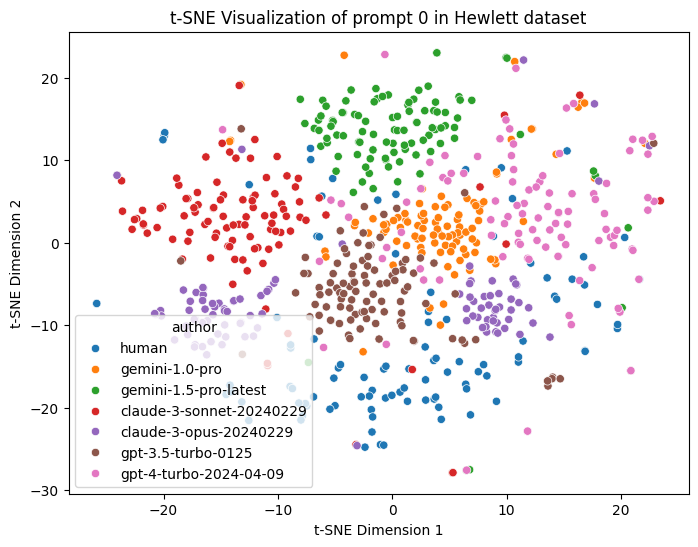

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

for dataset in ["reddit", "hewlett"]:
    dfs = []
    for author in authors:
        df = pd.read_csv(f"{dataset}_responses/{author}.csv")
        df["author"] = author
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    df = df[df["prompt_id"] == 0]

    z_scores_transformer = ZScoreTransformer(function_words=fw_oseah)
    z_scores = z_scores_transformer.fit_transform(df["text"])

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(z_scores)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df["author"])
    plt.title(f"t-SNE Visualization of prompt 0 in {dataset.capitalize()} dataset")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

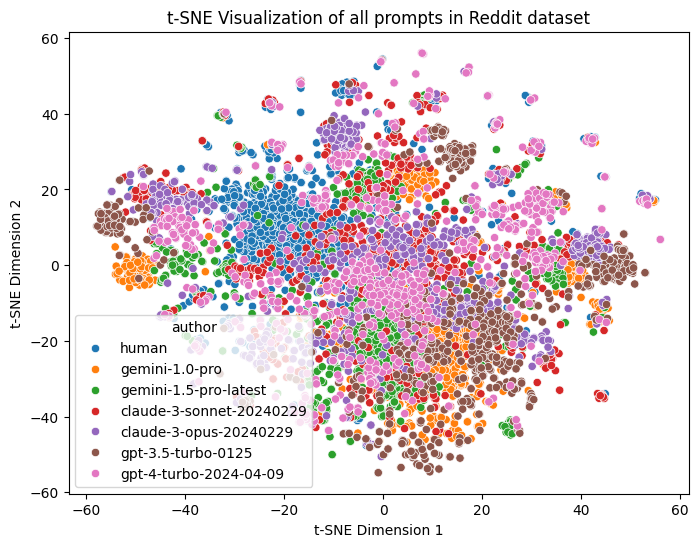

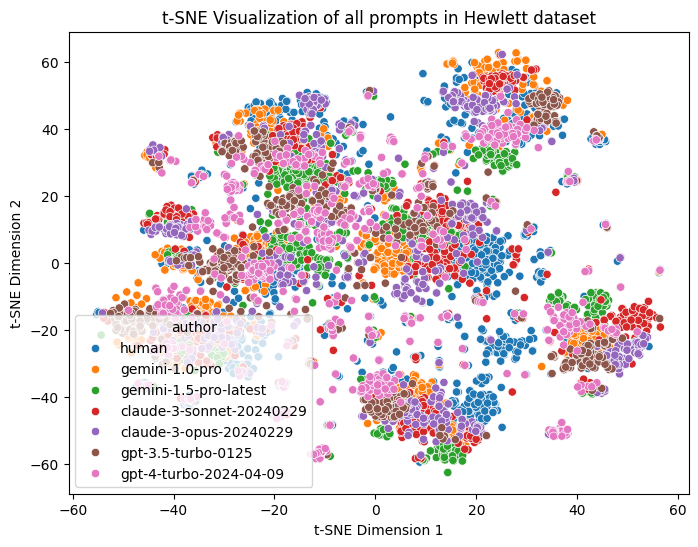

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

for dataset in ["reddit", "hewlett"]:
    dfs = []
    for author in authors:
        df = pd.read_csv(f"{dataset}_responses/{author}.csv")
        df["author"] = author
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)

    z_scores_transformer = ZScoreTransformer(function_words=fw_oseah)
    z_scores = z_scores_transformer.fit_transform(df["text"])

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(z_scores)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df["author"])
    plt.title(f"t-SNE Visualization of all prompts in {dataset.capitalize()} dataset")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()